# Decision making under uncertainty## Yibo Xu, 6299196

In this lecture, you learned about how the Markov decision process (MDP) framework can be extended to allow uncertainty about the states. This can be used to model a wide range of decision-making problems where there is uncertainty or noise associated with the state of the world.

We considered the example of the random dot motion discrimination task, where a subject must indicate the direction in which the majority of dots are moving. In this assignment, you will solve a two-stage formulation of this task, where the decision-maker can either make an immediate decision (i.e., at the first stage) on the basis of initial information, or choose to wait and gather further information before making their choice (i.e., at the second stage). The complete description of the problem can be found in the lecture slides and also in the original paper: http://www.gatsby.ucl.ac.uk/~dayan/papers/NDM002wc.pdf

Your task is to reproduce the plots from Figure 9 of the paper, interpret the results, and explain the steps of the solution.

In [2]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import seaborn as sns
import math
import sys
import os

## 0. Define the parameters of the model (0.5 pts)

In [3]:
# INSERT CODE HERE
states = np.array([1, 2, 3, 4])
observation = [stats.norm(6, 1), stats.norm(4, 1), stats.norm(6, 1), stats.norm(4, 1)]
rewards = [{"L": 1, "R": 0}, {"L": 0, "R": 1}, {"L": 1, "R": 0, "C": -1}, {"L": 0, "R": 1, "C": -1}]
prior = np.array([0.5, 0.5])
class node:
    def __init__(self, indexState, indexObservation, indexReward, indexPrior):
        self.indexState = indexState
        self.indexObservation = indexObservation
        self.indexReward = indexReward
        self.indexPrior = indexPrior
x1 = node(0, 0, 0, None)
x2 = node(1, 1, 1, None)
x3 = node(2, 2, 2, 0)
x4 = node(3, 3, 3, 1)
resolution = 1000

## 1. Updating the belief state  (2.5 pts)
The actual direction of motion ('state') is not completely observable to the subject. Hence, the subject can only rely on observations to compute the *belief* that the direction of motion is left or right (this is the posterior probability or 'belief state'). 

### 1a. Write a function that will calculate this posterior given the prior belief and an observation (the belief update). (0.5 pt)

In [4]:
# INSERT CODE BELOW
def posterior(n: node, nAlter: node):
    if n.indexPrior is None:
        return prior[n.indexPrior]
    else:
        likelihoodRatio = observation[n.indexObservation].pdf(np.linspace(0, 10, resolution)) / \
            observation[nAlter.indexObservation].pdf(np.linspace(0, 10, resolution))
        # print(likelihoodRatio.shape)
        return 1 / (1 + 1/likelihoodRatio*prior[n.indexPrior]/prior[nAlter.indexPrior])

### 1b. Use this function to update the belief on the first observation at step $\beta$ and reproduce Fig 9A.  Interpret the plot. (1 pt)

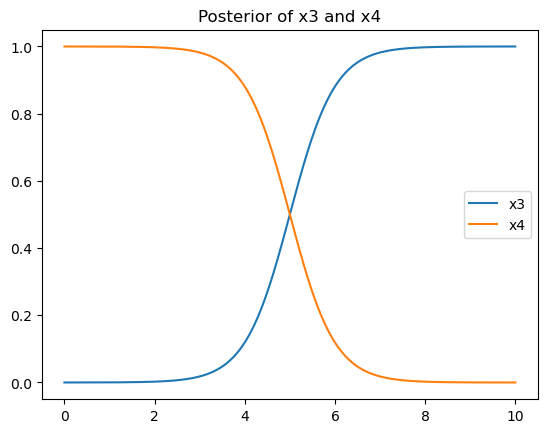

In [6]:
# INSERT CODE BELOW
plt.plot(np.linspace(0, 10, resolution), posterior(x3, x4), label="x3")
plt.plot(np.linspace(0, 10, resolution), posterior(x4, x3), label="x4")
plt.title("Posterior of x3 and x4")
plt.legend()

INSERT ANSWER BELOW

The posterior is the probability of the belief states. It describes the probability that the observation $c_\beta$ belongs to state $x_3$ or $x_4$. For $c_\beta = 5$, the probability of being in state $x_3$ and $x_4$ are the same.

### 1c. Write a function to update the belief on observing another sample at step $\alpha$ and reproduce Fig 9B.  Interpret the plot. (1 pt)
Hint: You will have to calculate this probability for every possible pair of observations.

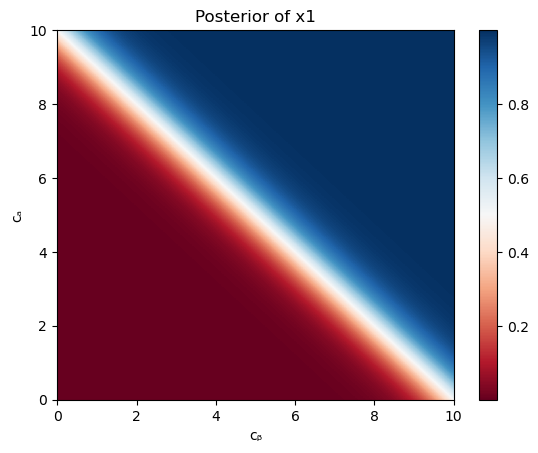

In [10]:
# INSERT CODE BELOW
def mixPosterior(n: node):
    if states[n.indexState] == 1:
        prev = x3
    elif states[n.indexState] == 2:
        prev = x4
    else:
        print("Error")
        sys.exit(1)
    pX, pY = np.meshgrid(observation[n.indexObservation].pdf(np.linspace(0, 10, resolution)), observation[n.indexObservation].pdf(np.linspace(0, 10, resolution)))
    return pX * pY * prior[prev.indexPrior]
# sns.heatmap(mixPosterior(x1), ax=plt)
c = plt.pcolormesh(np.linspace(0, 10, resolution), np.linspace(0, 10, resolution), mixPosterior(x1) / (mixPosterior(x1)+mixPosterior(x2)), cmap="RdBu")
plt.title("Posterior of x1")
plt.xlabel("c\u1D66")
plt.ylabel("c\u2090")
plt.colorbar(c)

INSERT ANSWER BELOW

$P(x_1|x_\beta, x_\alpha)\propto p(c_\alpha|x_1)p(c_\beta|x_3)P(x_3)/\mathrm{normalize\, factor}$. Since $(c_\alpha|x_1)$ and $(c_\beta|x_3)$ are i.i.d. distributed, the figure is symmetric about the $c_\beta=c_\alpha$.

When $c_\beta+c_\alpha=10$, $p(c_\alpha|x_1)=p(c_\beta|x_2)$ and $p(c_\alpha|x_2)=p(c_\beta|x_1)$ and $P(x_3)=P(x_4)$, so $P(x_1|x_\beta, x_\alpha)=P(x_2|x_\beta, x_\alpha)$.
Hence $P(x_1|x_\beta, x_\alpha)=0.5$ on the line $c_\beta+c_\alpha=10$.

## 2. Solving for the optimal actions (7 pts)
Now that we have a way to update the belief states, we can use them to determine the best course of action at each of the steps (the 'optimal policy'). 

### 2a. When finding the optimal policy, why does it make sense to calculate the best action at the final stage $\alpha$, and work backwards? (1 pt)

INSERT ANSWER BELOW

Because at the final stage $\alpha$, the optimal policy only depends on the immediate reward after the action. However, at the first stage $\beta$ the optimal policy depends on the reward estimation at stage $\alpha$.

### 2b. Write a function that will calculate the value of the best action at $\alpha$ and reproduce Fig 9C. Explain what the plot shows. (1 pt)

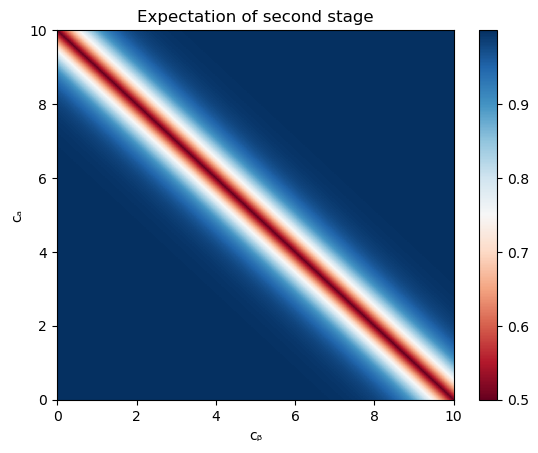

In [12]:
# INSERT CODE BELOW

chooseL = mixPosterior(x1) / (mixPosterior(x1)+mixPosterior(x2))
chooseR = mixPosterior(x2) / (mixPosterior(x1)+mixPosterior(x2))
c = plt.pcolormesh(np.linspace(0, 10, resolution), np.linspace(0, 10, resolution), np.maximum(chooseL, chooseR), cmap="RdBu")
plt.title("Expectation of second stage")
plt.xlabel("c\u1D66")
plt.ylabel("c\u2090")
plt.colorbar(c)

INSERT ANSWER BELOW

$V^*_{\alpha,c_\alpha,c_\beta}=\max\{P(x_1|c_\alpha, c_\beta), P(x_2|c_\alpha, c_\beta)\}$.
From the conclusion in the previous question, we know that when $c_\alpha+c_\beta=10$, the posterior probability of $x_1$ and $x_2$ are $0.5$, so the $v^*_{\alpha,c_\alpha,c_\beta}=0.5$ on this line. \
Moreover, When $|c_\beta+c_\alpha-10|$ increases, the maximum probability among $P(x_1|c_\alpha, c_\beta)$ and $P(x_2|c_\alpha, c_\beta)$ increases, which means the belief state gets more certain. \
So the expected reward under optimal policy increases when $|c_\beta+c_\alpha-10|$ increases.

### 2c. Before finding the best action at $\beta$, we have one more step to do. We need the values of the best actions at $\alpha$ that we just calculated and the probability of observing $c_{\alpha}$ given $c_{\beta}$ ($P(c_{\alpha} | c_{\beta})$). Why? (1 pt)

INSERT ANSWER BELOW

Because $c_\alpha$ and $c_\beta$ are correlated, the value of the best actions at $c_\alpha, c_\beta$ should be integrated with respect to measure (PDF) $p(c_\alpha|c_\beta)$ when calculating the contribution to the estimated reward of $c_\beta$.

### 2d. Write a function that will calculate $P(c_{\alpha} | c_{\beta})$ and reproduce Fig 9D. Explain how you calculated this probability and what the plot shows. (1 pt)
Hint: You will have to marginalise the posteriors over the possible states.

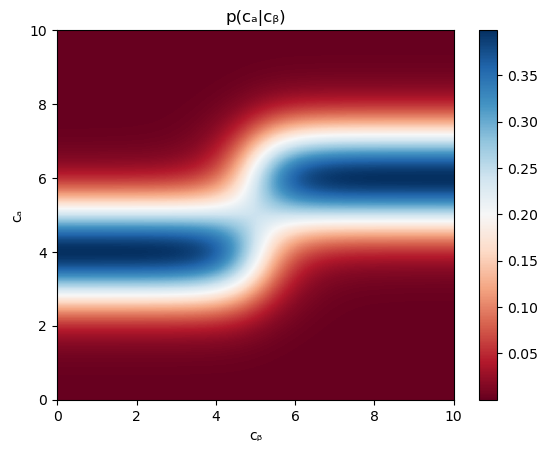

In [13]:
# INSERT CODE BELOW
def conditionalObservation():
    X1, Y1 = np.meshgrid(posterior(x3, x4), observation[x1.indexObservation].pdf(np.linspace(0, 10, resolution)))
    X2, Y2 = np.meshgrid(posterior(x4, x3), observation[x2.indexObservation].pdf(np.linspace(0, 10, resolution)))
    return X1*Y1 + X2*Y2
c = plt.pcolormesh(np.linspace(0, 10, resolution), np.linspace(0, 10, resolution), conditionalObservation(), cmap="RdBu")
plt.title("p(c\u2090|c\u1D66)")
plt.xlabel("c\u1D66")
plt.ylabel("c\u2090")
plt.colorbar(c)

INSERT ANSWER BELOW

$p(c_\alpha|c_\beta) = p(c_\alpha|x_1)p(x_3|c_\beta) + p(c_\alpha|x_2)p(x_4|c_\beta)$. \
When $c_\beta>5$, $p(c_\alpha|x_2)p(x_4|c_\beta)$ dominates, and $p(c_\alpha|x_2)$ peaks at $c_\alpha=6$. \
When $c_\beta<5$, $p(c_\alpha|x_1)p(x_3|c_\beta)$ dominates, and $p(c_\alpha|x_1)$ peaks at $c_\alpha=4$.


### 2e. We are now ready to find the best action at $\beta$. Write a function that calculates the values associated with each of the actions and reproduce Fig 9E. What does the plot tell you about what the best action is at $\beta$? (1 pt)
Hint: For action C, you will have to numerically integrate over possible observations ${c_{\alpha}}$ using the step size ($dc_{\alpha}$) you defined on your Gaussian observation distribution. 

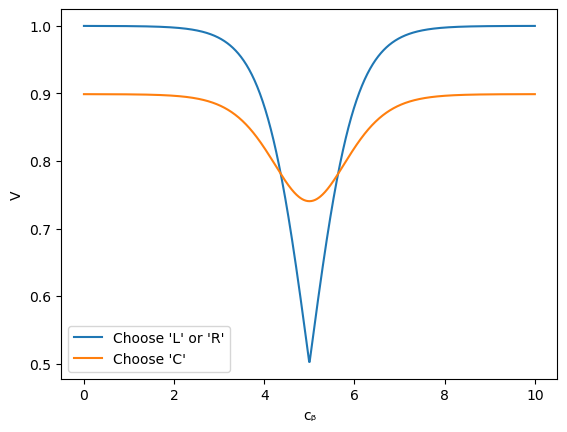

In [18]:
# INSERT CODE BELOW
expect = (np.maximum(chooseL, chooseR) * conditionalObservation()).sum(axis=0) * 10 / resolution
plt.plot(np.linspace(0, 10, resolution), np.maximum(posterior(x3, x4), posterior(x4, x3)), label="Choose 'L' or 'R'")
plt.plot(np.linspace(0, 10, resolution), expect-0.1, label="Choose 'C'")
plt.xlabel("c\u1D66")
plt.ylabel("V")
plt.legend()

INSERT ANSWER BELOW

When $c_\beta$ is close to 5, the uncertainty of the hidden state is high, hence additional observation is needed to improve the performance, "C" is optimal. \
When $c_\beta$ is far away from 5, the uncertainty of the hidden state is low, hence it is better to make choice immediately to avoid punishment.

### 2f. What will reduce (or increase) the range of observations at $\beta$ where it is best to choose to wait for another observation (choosing C)? Can you tweak a parameter to do this and produce a plot similar to Fig 9E to show this? (2 pts)
Hint: You will have to re-run the steps with this changed parameter. 

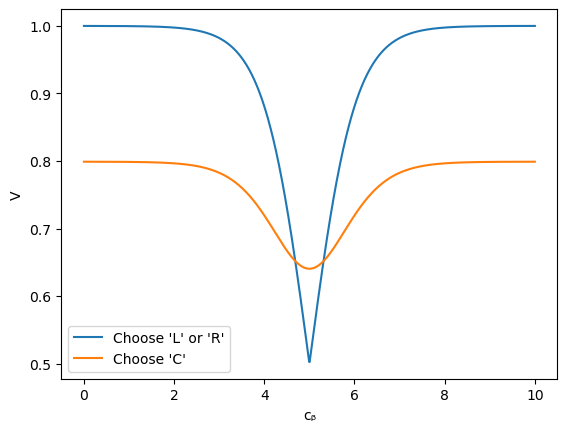

In [19]:
# INSERT CODE BELOW
expect = (np.maximum(chooseL, chooseR) * conditionalObservation()).sum(axis=0) * 10 / resolution
plt.plot(np.linspace(0, 10, resolution), np.maximum(posterior(x3, x4), posterior(x4, x3)), label="Choose 'L' or 'R'")
plt.plot(np.linspace(0, 10, resolution), expect-0.2, label="Choose 'C'")
plt.xlabel("c\u1D66")
plt.ylabel("V")
plt.legend()

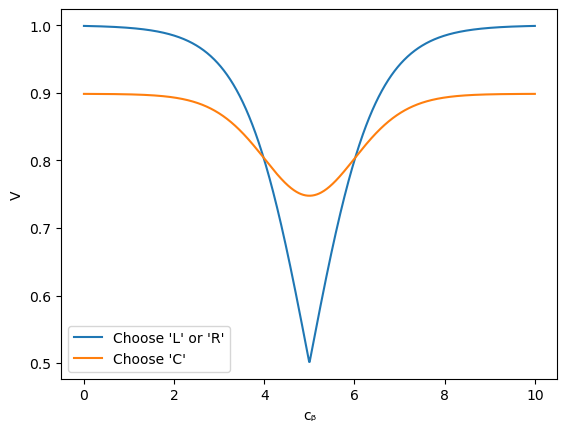

In [25]:
observation = [stats.norm(6, 1.2), stats.norm(4, 1.2), stats.norm(6, 1.2), stats.norm(4, 1.2)]
chooseNewL = mixPosterior(x1) / (mixPosterior(x1)+mixPosterior(x2))
chooseNewR = mixPosterior(x2) / (mixPosterior(x1)+mixPosterior(x2))
expect = (np.maximum(chooseL, chooseR) * conditionalObservation()).sum(axis=0) * 10 / resolution
plt.plot(np.linspace(0, 10, resolution), np.maximum(posterior(x3, x4), posterior(x4, x3)), label="Choose 'L' or 'R'")
plt.plot(np.linspace(0, 10, resolution), expect-0.1, label="Choose 'C'")
plt.xlabel("c\u1D66")
plt.ylabel("V")
plt.legend()

INSERT ANSWER BELOW

When increasing the punishment of choosine "C", it reduces the range of "C" as the optimal choice. \
When increasing the standard deviation of the observation under conditioned hidden state, the range expands.
